In [1]:
import pandas as pd 
import numpy as np
import joblib
import os
import sklearn
import xgboost
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold


In [2]:
print("Python:", os.sys.version)
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("scikit-learn:", sklearn.__version__)
print("xgboost:", xgboost.__version__)
print("joblib:", joblib.__version__)

Python: 3.13.2 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 18:49:14) [MSC v.1929 64 bit (AMD64)]
pandas: 2.2.3
numpy: 2.2.5
scikit-learn: 1.6.1
xgboost: 3.0.1
joblib: 1.5.1


## Environment dan Versi Library

Notebook ini dijalankan menggunakan **Python 3.13.2 (Anaconda)** dengan versi library sebagai berikut:

| Library       | Version  |
|---------------|----------|
| pandas        | 2.2.3    |
| numpy         | 2.2.5    |
| scikit-learn  | 1.6.1    |
| xgboost       | 3.0.1    |
| joblib        | 1.5.1    |

Untuk mereplikasi environment ini, jalankan:
```bash
pip install -r requirements.txt


## Pipeline Data Preprocessing

In [3]:
# =====================
# 1. Load data from CSV
# =====================
train_df = pd.read_csv("dataset/train.csv")
test_df = pd.read_csv("dataset/test.csv")

X_train = train_df.drop(["HiringDecision", "Age", "DistanceFromCompany", "Gender",'PreviousCompanies'], axis=1)
y_train = train_df["HiringDecision"]

X_test = test_df.drop(["HiringDecision", "Age", "DistanceFromCompany", "Gender",'PreviousCompanies'], axis=1)
y_test = test_df["HiringDecision"]



In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  1200 non-null   int64  
 1   Gender               1200 non-null   int64  
 2   EducationLevel       1200 non-null   int64  
 3   ExperienceYears      1200 non-null   int64  
 4   PreviousCompanies    1200 non-null   int64  
 5   DistanceFromCompany  1200 non-null   float64
 6   InterviewScore       1200 non-null   int64  
 7   SkillScore           1200 non-null   int64  
 8   PersonalityScore     1200 non-null   int64  
 9   RecruitmentStrategy  1200 non-null   int64  
 10  HiringDecision       1200 non-null   int64  
dtypes: float64(1), int64(10)
memory usage: 103.3 KB


## Preprocesing

In [5]:

# =====================
# 3. Preprocessing setup
# =====================

class DataCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # 1. Drop duplicates
        X = X.drop_duplicates()
        
        # 2. Missing value handling
        for col in X.select_dtypes(include=["float", "int"]).columns:
            X[col] = X[col].fillna(X[col].median())   # numeric → median
        for col in X.select_dtypes(include=["object"]).columns:
            X[col] = X[col].fillna(X[col].mode()[0]) # categorical → modus
        
        # 3. Outlier handling (IQR method pada numerical)
        for col in X.select_dtypes(include=["float", "int"]).columns:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
            X[col] = np.where(X[col] < lower, lower,
                              np.where(X[col] > upper, upper, X[col]))
        
        return X
    
# b. ExperienceYears → binning (junior/mid/senior)
def bin_experience(x):
    bins = np.array(x).astype(int).ravel()
    labels = []
    for v in bins:
        if v <=2:
            labels.append("Junior")
        elif v <=5:
            labels.append("Mid")
        else:
            labels.append("Senior")
    return np.array(labels).reshape(-1,1)


# a. EducationLevel → OH encode
edu_pipeline = Pipeline([
    ("onehot", OneHotEncoder(drop="first"))  # one-hot encode EducationLevel
])

exp_pipeline = Pipeline([
    ("binning", FunctionTransformer(bin_experience, validate=False,feature_names_out="one-to-one")),
    ("onehot", OneHotEncoder(drop="first"))  # one-hot encode hasil binning
])

# c. RecruitmentStrategy → one-hot encode
recruitment_pipeline = Pipeline([
    ("onehot", OneHotEncoder(drop="first"))
])

# d. Numerical features → scaling
num_features = ["InterviewScore", "SkillScore", "PersonalityScore"]
num_pipeline = Pipeline([
    ("scaler", StandardScaler())
])

# =====================
# 4. ColumnTransformer
# =====================
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, num_features),
        ("recruitment", recruitment_pipeline, ["RecruitmentStrategy"]),
        ("education", edu_pipeline, ["EducationLevel"]),        
        ("experience", exp_pipeline, ["ExperienceYears"])
        
    ],
    remainder="drop"
)


# Pipeline gabungan: cleaning + preprocessing


preprocessor.fit(X_train)
# # Simpan pipeline preprocessing
joblib.dump(preprocessor, "preprocesor.pkl")
print("Pipeline preprocessing berhasil disimpan.")



full_pipeline = Pipeline([
    ("cleaning", DataCleaner()),   # tahap cleaning
    ("preprocessing", preprocessor) # tahap preprocessing (OH, scaling, dsb.)
])
# Transform data
X_train_transformed = full_pipeline.fit_transform(X_train)
X_test_transformed  = full_pipeline.transform(X_test)

print("Train shape:", X_train_transformed.shape)
print("Test shape :", X_test_transformed.shape)





Pipeline preprocessing berhasil disimpan.
Train shape: (1200, 10)
Test shape : (300, 10)


## Check data 

In [6]:

# 1. Education (one-hot)
edu_encoder = preprocessor.named_transformers_["education"].named_steps["onehot"]
edu_cols = edu_encoder.get_feature_names_out(["EducationLevel"]).tolist()

# 2. ExperienceYears (binning + onehot drop="first" → 2 kolom)
exp_cols = ["ExperienceLevel_Mid", "ExperienceLevel_Senior"]

# 3. RecruitmentStrategy (ambil langsung dari OneHotEncoder)
recruitment_encoder = preprocessor.named_transformers_["recruitment"].named_steps["onehot"]
recruitment_cols = recruitment_encoder.get_feature_names_out(["RecruitmentStrategy"]).tolist()

# 5. Numeric features
num_cols = num_features

# Gabung semua nama kolom
all_cols =  edu_cols + exp_cols + recruitment_cols + num_cols

# Buat DataFrame hasil transform
X_train_df = pd.DataFrame(X_train_transformed, columns=all_cols, index=X_train.index)
X_test_df  = pd.DataFrame(X_test_transformed, columns=all_cols, index=X_test.index)

X_train_df.shape


(1200, 10)

In [7]:
display(X_train_df.head())
X_train_df.shape

,EducationLevel_2.0,EducationLevel_3.0,EducationLevel_4.0,ExperienceLevel_Mid,ExperienceLevel_Senior,RecruitmentStrategy_2.0,RecruitmentStrategy_3.0,InterviewScore,SkillScore,PersonalityScore
0,-0.183148,1.242828,0.924557,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1.635513,0.800611,1.637344,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.201568,-1.206373,-0.195535,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.567865,-0.560056,1.603402,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,-1.092479,-0.900223,-1.553224,0.0,0.0,1.0,0.0,0.0,1.0,0.0


(1200, 10)

In [8]:
X_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EducationLevel_2.0       300 non-null    float64
 1   EducationLevel_3.0       300 non-null    float64
 2   EducationLevel_4.0       300 non-null    float64
 3   ExperienceLevel_Mid      300 non-null    float64
 4   ExperienceLevel_Senior   300 non-null    float64
 5   RecruitmentStrategy_2.0  300 non-null    float64
 6   RecruitmentStrategy_3.0  300 non-null    float64
 7   InterviewScore           300 non-null    float64
 8   SkillScore               300 non-null    float64
 9   PersonalityScore         300 non-null    float64
dtypes: float64(10)
memory usage: 23.6 KB


In [9]:
display(X_test_df.head())
X_test_df.shape

,EducationLevel_2.0,EducationLevel_3.0,EducationLevel_4.0,ExperienceLevel_Mid,ExperienceLevel_Senior,RecruitmentStrategy_2.0,RecruitmentStrategy_3.0,InterviewScore,SkillScore,PersonalityScore
0,1.530590,0.630528,-0.942264,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.306491,-0.900223,-1.553224,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,1.565564,0.664544,1.569459,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-1.442222,1.480945,-0.195535,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.936028,-1.512523,-0.602842,1.0,0.0,0.0,0.0,0.0,0.0,1.0


(300, 10)

## Modeling

In [10]:
def evaluate_and_rank_models(models, X_train, y_train, X_test, y_test):
    """
    Melatih, mengevaluasi, dan mengurutkan model berdasarkan performa pada data uji.
    
    Args:
        models (dict): Kamus berisi model-model yang sudah diinisialisasi.
        X_train, y_train: Data latih.
        X_test, y_test: Data uji.
        
    Returns:
        pd.DataFrame: DataFrame yang berisi hasil evaluasi model yang diurutkan
                      berdasarkan metrik ROC-AUC.
    """
    
    # 1. Melatih semua model
    for name, model in models.items():
        # print(f"Melatih model: {name}...")
        model.fit(X_train, y_train)
        
    # 2. Mengevaluasi model dan mengumpulkan hasilnya
    results = []
    
    for name, model in models.items():
        y_pred = model.predict(X_test)
        
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)[:, 1]
        else:
            y_prob = model.decision_function(X_test)
        
        acc  = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec  = recall_score(y_test, y_pred)
        f1   = f1_score(y_test, y_pred)
        auc  = roc_auc_score(y_test, y_prob)
        
        results.append({
            "Model": name,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1-Score": f1,
            "ROC-AUC": auc
        })
        
    # 3. Membuat DataFrame dan mengurutkan
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by="ROC-AUC", ascending=False)
    
    return results_df



def calculate_overfitting_gap(models, X_train, y_train, X_test, y_test, sort_by='F1-Score Gap (%)'):
    """
    Menghitung dan menampilkan gap overfitting (persentase perbedaan)
    untuk beberapa model, diurutkan berdasarkan gap terkecil.

    Args:
        models (dict): Kamus berisi model-model yang sudah dilatih.
        X_train, y_train: Fitur dan target untuk data latih.
        X_test, y_test: Fitur dan target untuk data uji.
        sort_by (str): Nama kolom metrik untuk mengurutkan hasil.
                       Default adalah 'F1-Score Gap (%)'.

    Returns:
        pd.DataFrame: DataFrame yang menampilkan persentase gap untuk setiap metrik,
                      diurutkan dari gap terkecil ke terbesar.
    """
    gap_data = []

    for name, model in models.items():
        model.fit(X_train, y_train)
        # Hitung metrik untuk data latih
        y_train_pred = model.predict(X_train)
        y_train_prob = model.predict_proba(X_train)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_train)
        
        metrics_train = {
            'Accuracy': accuracy_score(y_train, y_train_pred),
            'Precision': precision_score(y_train, y_train_pred),
            'Recall': recall_score(y_train, y_train_pred),
            'F1-Score': f1_score(y_train, y_train_pred),
            'ROC-AUC': roc_auc_score(y_train, y_train_prob)
        }

        # Hitung metrik untuk data uji
        y_test_pred = model.predict(X_test)
        y_test_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

        metrics_test = {
            'Accuracy': accuracy_score(y_test, y_test_pred),
            'Precision': precision_score(y_test, y_test_pred),
            'Recall': recall_score(y_test, y_test_pred),
            'F1-Score': f1_score(y_test, y_test_pred),
            'ROC-AUC': roc_auc_score(y_test, y_test_prob)
        }
        
        # Hitung persentase gap untuk setiap metrik
        gaps = {
            "Model": name,
            "Accuracy Gap (%)": (metrics_train['Accuracy'] - metrics_test['Accuracy']) / metrics_train['Accuracy'] * 100,
            "Precision Gap (%)": (metrics_train['Precision'] - metrics_test['Precision']) / metrics_train['Precision'] * 100,
            "Recall Gap (%)": (metrics_train['Recall'] - metrics_test['Recall']) / metrics_train['Recall'] * 100,
            "F1-Score Gap (%)": (metrics_train['F1-Score'] - metrics_test['F1-Score']) / metrics_train['F1-Score'] * 100,
            "ROC-AUC Gap (%)": (metrics_train['ROC-AUC'] - metrics_test['ROC-AUC']) / metrics_train['ROC-AUC'] * 100
        }
        
        gap_data.append(gaps)

    df_gaps = pd.DataFrame(gap_data).set_index("Model")
    return df_gaps.sort_values(by=sort_by, ascending=True)

def evaluate_and_display(model, X_train, y_train, X_test, y_test):
    """
    Mengevaluasi model pada data train dan test,
    lalu menampilkan hasilnya dalam bentuk DataFrame,
    termasuk gap (%) antara train dan test.
    """
    # === TRAIN ===
    y_train_pred = model.predict(X_train)
    y_train_prob = model.predict_proba(X_train)[:, 1]
    report_train = classification_report(y_train, y_train_pred, output_dict=True)
    roc_auc_train = roc_auc_score(y_train, y_train_prob)

    # === TEST ===
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)[:, 1]
    report_test = classification_report(y_test, y_test_pred, output_dict=True)
    roc_auc_test = roc_auc_score(y_test, y_test_prob)

    # === Gabungkan semua metrik ===
    metrics = {
        "Precision (class 1)": [round(report_train["1"]["precision"], 3), round(report_test["1"]["precision"], 3)],
        "Recall (class 1)":    [round(report_train["1"]["recall"], 3),    round(report_test["1"]["recall"], 3)],
        "F1-score (class 1)":  [round(report_train["1"]["f1-score"], 3),  round(report_test["1"]["f1-score"], 3)],
        "Accuracy":            [round(report_train["accuracy"], 3),       round(report_test["accuracy"], 3)],
        "ROC AUC":             [round(roc_auc_train, 3),                  round(roc_auc_test, 3)]
    }

    df_metrics = pd.DataFrame(metrics, index=["Train", "Test"])

    # === Hitung Gap (%) ===
    # (Train - Test) / Train * 100
    gap_values = ((df_metrics.loc["Train"] - df_metrics.loc["Test"]) 
                  / df_metrics.loc["Train"] * 100).round(2)

    df_metrics.loc["Gap (%)"] = gap_values

    return df_metrics




### Base Model LogisticRegression

In [11]:
# Model
model = LogisticRegression(max_iter=1000, random_state=42,class_weight="balanced")
model.fit(X_train_transformed, y_train)

# =====================
# 7. Evaluation
# =====================
y_pred = model.predict(X_test_transformed)
y_prob = model.predict_proba(X_test_transformed)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

# # =====================
# # 8. Save Model + Preprocessor
# # =====================
# import joblib
# joblib.dump(preprocessor, "preprocessor.pkl")
# joblib.dump(model, "logreg_model.pkl")

              precision    recall  f1-score   support

           0       0.94      0.88      0.91       207
           1       0.76      0.87      0.81        93

    accuracy                           0.88       300
   macro avg       0.85      0.88      0.86       300
weighted avg       0.88      0.88      0.88       300

ROC AUC: 0.9219780790608281


In [12]:
result_eval_baseline = evaluate_and_display(model, X_train_transformed, y_train, X_test_transformed, y_test)
print("Hasil Evaluasi Model (dengan Gap):")
display(result_eval_baseline)

Hasil Evaluasi Model (dengan Gap):


,Precision (class 1),Recall (class 1),F1-score (class 1),Accuracy,ROC AUC
Train,0.756,0.892,0.819,0.877,0.927
Test,0.764,0.871,0.814,0.877,0.922
Gap (%),-1.060,2.350,0.610,0.000,0.540


In [13]:
# # Nama folder yang diinginkan
# folder_path = 'file_exp'

# # Cek apakah folder sudah ada, jika tidak, buat folder tersebut
# if not os.path.exists(folder_path):
#     os.path.makedirs(folder_path)
#     print(f"Folder '{folder_path}' berhasil dibuat.")

# # Buat path lengkap untuk file Excel
# file_path = os.path.join(folder_path, 'result_eval_baseline.xlsx')

# # Asumsikan 'hasil_evaluasi' adalah DataFrame
# result_eval_baseline.to_excel(file_path, index=True)

# print(f"Hasil evaluasi telah berhasil disimpan ke: {file_path}")

## Test to many models

In [14]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42,class_weight="balanced"),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(
        eval_metric="logloss",
        random_state=42
    )
}

In [15]:
result_eval_7model = evaluate_and_rank_models(models, X_train_transformed, y_train, X_test_transformed, y_test)
print("Hasil Evaluasi Model:")
display(result_eval_7model)

models3 = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(
        eval_metric="logloss",
        random_state=42
    )
}
result_eval_7model_gap = calculate_overfitting_gap(models3, X_train_transformed, y_train, X_test_transformed, y_test)
print("Hasil Evaluasi Model (dengan Gap):")
display(result_eval_7model_gap)

Hasil Evaluasi Model:


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
3,Random Forest,0.920000,0.960000,0.774194,0.857143,0.939691
4,Gradient Boosting,0.923333,0.960526,0.784946,0.863905,0.932757
7,XGBoost,0.903333,0.910256,0.763441,0.830409,0.928367
5,SVM,0.913333,0.958904,0.752688,0.843373,0.928315
0,Logistic Regression,0.876667,0.764151,0.870968,0.814070,0.921978
1,KNN,0.860000,0.840000,0.677419,0.750000,0.915147
6,Naive Bayes,0.796667,0.728571,0.548387,0.625767,0.841619
2,Decision Tree,0.860000,0.831169,0.688172,0.752941,0.812685


Hasil Evaluasi Model (dengan Gap):


,Accuracy Gap (%),Precision Gap (%),Recall Gap (%),F1-Score Gap (%),ROC-AUC Gap (%)
Model,,,,,
Gradient Boosting,4.317789,0.848896,14.369501,8.289229,3.532126
Random Forest,7.923269,4.000000,22.371968,14.170196,6.030856
XGBoost,9.666667,8.974359,23.655914,16.959064,7.163264


In [16]:
# # Nama folder yang diinginkan
# folder_path = 'file_exp'

# # Cek apakah folder sudah ada, jika tidak, buat folder tersebut
# if not os.path.exists(folder_path):
#     os.path.makedirs(folder_path)
#     print(f"Folder '{folder_path}' berhasil dibuat.")

# # Buat path lengkap untuk file pertama
# file_path_1 = os.path.join(folder_path, 'result_eval_7model.xlsx')
# # Buat path lengkap untuk file kedua
# file_path_2 = os.path.join(folder_path, 'result_eval_7model_gap.xlsx')

# # Simpan DataFrame pertama ke file pertama
# result_eval_7model.to_excel(file_path_1, index=True)

# # Simpan DataFrame kedua ke file kedua
# result_eval_7model_gap.to_excel(file_path_2, index=True)

# print(f"Hasil evaluasi pertama berhasil disimpan ke: {file_path_1}")
# print(f"Hasil evaluasi kedua berhasil disimpan ke: {file_path_2}")

Jika ingin performa tertinggi (F1-Score + Recall balance) → Gradient Boosting.

Jika ingin pemisahan kelas terbaik (ROC-AUC tertinggi) → Random Forest.h.

# Hyperparameter Tuning untuk random forest dan gradient boosting

## Random forest , Gradient Boosting & XGBoost

In [17]:
# =========================================
# Fungsi Evaluasi Model (Train vs Test)
# =========================================
def evaluate_train_test(model, X_train, y_train, X_test, y_test, model_name="Model"):
    # Prediksi Train
    y_train_pred = model.predict(X_train)
    y_train_prob = model.predict_proba(X_train)[:, 1]

    # Prediksi Test
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)[:, 1]

    # Hasil Train
    train_results = {
        "Accuracy": accuracy_score(y_train, y_train_pred),
        "Precision": precision_score(y_train, y_train_pred),
        "Recall": recall_score(y_train, y_train_pred),
        "F1-Score": f1_score(y_train, y_train_pred),
        "ROC-AUC": roc_auc_score(y_train, y_train_prob)
    }

    # Hasil Test
    test_results = {
        "Accuracy": accuracy_score(y_test, y_test_pred),
        "Precision": precision_score(y_test, y_test_pred),
        "Recall": recall_score(y_test, y_test_pred),
        "F1-Score": f1_score(y_test, y_test_pred),
        "ROC-AUC": roc_auc_score(y_test, y_test_prob)
    }

    # Gap (%)
    gap_results = {m: (train_results[m] - test_results[m]) for m in train_results}

    # Buat DataFrame untuk tampilan tabel
    df_results = pd.DataFrame([
        {"Model": model_name, "Dataset": "Train", **train_results},
        {"Model": model_name, "Dataset": "Test", **test_results},
        {"Model": model_name, "Dataset": "Gap (%)", **gap_results},
    ])

    return df_results

In [18]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# =========================================
# Random Forest dengan RandomizedSearchCV
# =========================================
rf = RandomForestClassifier(random_state=42)

rf_param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [2, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_dist,
    n_iter=20,
    cv=cv,
    scoring='f1',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# ✅ gunakan X_train_transformed dan X_test_transformed
rf_random.fit(X_train_transformed, y_train)

print("="*40)
print("===== Hasil Hyperparameter Tuning (Random Forest) =====")
print("Best Hyperparameter:", rf_random.best_params_)
print("Best F1 Score :", rf_random.best_score_)

# Evaluasi Train vs Test
best_rf = rf_random.best_estimator_
df_rf_eval = evaluate_train_test(best_rf, X_train_transformed, y_train,
                                 X_test_transformed, y_test,
                                 model_name="Random Forest")
print("\nResult Model evaluation Train vs Test:\n")
display(df_rf_eval)

# =========================================
# 2. Gradient Boosting
# =========================================
gb = GradientBoostingClassifier(random_state=42)
gb_param_dist = {
    'n_estimators': np.arange(100, 501, 50),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'max_depth': [2, 3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.6, 0.8, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

gb_random = RandomizedSearchCV(
    estimator=gb,
    param_distributions=gb_param_dist,
    n_iter=30,
    cv=cv,
    scoring='f1',
    verbose=2,
    random_state=42,
    n_jobs=-1
)
gb_random.fit(X_train_transformed, y_train)

print("="*40)
print("===== Hasil Hyperparameter Tuning (Gradient Boosting) =====")
print("Best Hyperparameter:", gb_random.best_params_)
print("Best F1 Score :", gb_random.best_score_)

best_gb = gb_random.best_estimator_
df_gb_eval = evaluate_train_test(best_gb, X_train_transformed, y_train,
                                 X_test_transformed, y_test,
                                 model_name="Gradient Boosting")
display(df_gb_eval)

# =========================================
# 3. XGBoost
# =========================================
xgb = XGBClassifier(random_state=42, eval_metric='logloss')


xgb_param_dist = {
    'n_estimators': np.arange(100, 501, 50),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'max_depth': [2, 3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5]
}

xgb_random = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_dist,
    n_iter=30,
    cv=cv,
    scoring='f1',
    verbose=2,
    random_state=42,
    n_jobs=-1
)
xgb_random.fit(X_train_transformed, y_train)

print("="*40)
print("===== Hasil Hyperparameter Tuning (XGBoost) =====")
print("Best Hyperparameter:", xgb_random.best_params_)
print("Best F1 Score :", xgb_random.best_score_)

best_xgb = xgb_random.best_estimator_
df_xgb_eval = evaluate_train_test(best_xgb, X_train_transformed, y_train,
                                  X_test_transformed, y_test,
                                  model_name="XGBoost")
display(df_xgb_eval)


# =========================================
# Gabungkan semua hasil evaluasi jadi 1 tabel
# =========================================
final_results = pd.concat([df_rf_eval, df_gb_eval, df_xgb_eval], ignore_index=True)
print("\n================ Final Comparison ================")
display(final_results)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
===== Hasil Hyperparameter Tuning (Random Forest) =====
Best Hyperparameter: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}
Best F1 Score : 0.8545507537384724

Result Model evaluation Train vs Test:



,Model,Dataset,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Random Forest,Train,0.965000,0.974138,0.911290,0.941667,0.998283
1,Random Forest,Test,0.926667,0.961039,0.795699,0.870588,0.935016
2,Random Forest,Gap (%),0.038333,0.013099,0.115591,0.071078,0.063266


Fitting 5 folds for each of 30 candidates, totalling 150 fits
===== Hasil Hyperparameter Tuning (Gradient Boosting) =====
Best Hyperparameter: {'subsample': 1.0, 'n_estimators': np.int64(100), 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 2, 'learning_rate': np.float64(0.2677777777777778)}
Best F1 Score : 0.8788596726958133


,Model,Dataset,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Gradient Boosting,Train,0.960833,0.962963,0.908602,0.934993,0.957296
1,Gradient Boosting,Test,0.933333,0.939759,0.838710,0.886364,0.934757
2,Gradient Boosting,Gap (%),0.027500,0.023204,0.069892,0.048629,0.022539


Fitting 5 folds for each of 30 candidates, totalling 150 fits
===== Hasil Hyperparameter Tuning (XGBoost) =====
Best Hyperparameter: {'subsample': 0.6, 'n_estimators': np.int64(500), 'max_depth': 2, 'learning_rate': np.float64(0.3), 'gamma': 5, 'colsample_bytree': 0.8}
Best F1 Score : 0.8815239920074692


,Model,Dataset,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,XGBoost,Train,0.958333,0.968023,0.895161,0.930168,0.947551
1,XGBoost,Test,0.946667,0.963855,0.860215,0.909091,0.935406
2,XGBoost,Gap (%),0.011667,0.004168,0.034946,0.021077,0.012145



================ Final Comparison ================


,Model,Dataset,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Random Forest,Train,0.965000,0.974138,0.911290,0.941667,0.998283
1,Random Forest,Test,0.926667,0.961039,0.795699,0.870588,0.935016
2,Random Forest,Gap (%),0.038333,0.013099,0.115591,0.071078,0.063266
3,Gradient Boosting,Train,0.960833,0.962963,0.908602,0.934993,0.957296
4,Gradient Boosting,Test,0.933333,0.939759,0.838710,0.886364,0.934757
5,Gradient Boosting,Gap (%),0.027500,0.023204,0.069892,0.048629,0.022539
6,XGBoost,Train,0.958333,0.968023,0.895161,0.930168,0.947551
7,XGBoost,Test,0.946667,0.963855,0.860215,0.909091,0.935406
8,XGBoost,Gap (%),0.011667,0.004168,0.034946,0.021077,0.012145


In [ ]:
# # Nama folder yang diinginkan
# folder_path = 'file_exp'

# # Cek apakah folder sudah ada, jika tidak, buat folder tersebut
# if not os.path.exists(folder_path):
#     os.makedirs(folder_path)
#     print(f"Folder '{folder_path}' berhasil dibuat.")

# # Buat path lengkap untuk file Excel
# file_path = os.path.join(folder_path, 'final_result.xlsx')

# # Asumsikan 'hasil_evaluasi' adalah DataFrame
# final_results.to_excel(file_path, index=True)

# print(f"Hasil evaluasi telah berhasil disimpan ke: {file_path}")

Hasil evaluasi telah berhasil disimpan ke: file_exp\final_result.xlsx


## XGBoost Best Performance Model

In [20]:
# =========================================
# 3. XGBoost
# =========================================
xgb = XGBClassifier(random_state=42, eval_metric='logloss')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb_param_dist = {
    'n_estimators': np.arange(100, 501, 50),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'max_depth': [2, 3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5]
}

xgb_random = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_dist,
    n_iter=30,
    cv=cv,
    scoring='f1',
    verbose=2,
    random_state=42,
    n_jobs=-1
)
xgb_random.fit(X_train_transformed, y_train)

print("="*40)
print("===== Hasil Hyperparameter Tuning  RandomizedSearchCV (XGBoost) =====")
print("Best Hyperparameter:", xgb_random.best_params_)
print("Best F1 Score :", xgb_random.best_score_)

best_xgb = xgb_random.best_estimator_
df_xgb_eval = evaluate_train_test(best_xgb, X_train_transformed, y_train,
                                  X_test_transformed, y_test,
                                  model_name="XGBoost")
display(df_xgb_eval)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
===== Hasil Hyperparameter Tuning  RandomizedSearchCV (XGBoost) =====
Best Hyperparameter: {'subsample': 0.6, 'n_estimators': np.int64(500), 'max_depth': 2, 'learning_rate': np.float64(0.3), 'gamma': 5, 'colsample_bytree': 0.8}
Best F1 Score : 0.8815239920074692


,Model,Dataset,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,XGBoost,Train,0.958333,0.968023,0.895161,0.930168,0.947551
1,XGBoost,Test,0.946667,0.963855,0.860215,0.909091,0.935406
2,XGBoost,Gap (%),0.011667,0.004168,0.034946,0.021077,0.012145


In [21]:
# # =========================================
# # XGBoost - Grid Search
# # =========================================
# from sklearn.model_selection import GridSearchCV

# xgb = XGBClassifier(random_state=42, eval_metric='logloss')

# xgb_param_grid = {
#     'n_estimators': [100, 200, 300, 400, 500],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
#     'max_depth': [2, 3, 5, 7],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'gamma': [0, 1, 5]
# }

# xgb_grid = GridSearchCV(
#     estimator=xgb,
#     param_grid=xgb_param_grid,
#     cv=cv,
#     scoring='f1',
#     verbose=2,
#     n_jobs=-1
# )
# xgb_grid.fit(X_train_transformed, y_train)

# print("="*40)
# print("===== Hasil Hyperparameter Tuning  GridSearchCV (XGBoost) =====")
# print("Best Hyperparameter:", xgb_grid.best_params_)
# print("Best F1 Score :", xgb_grid.best_score_)

# best_xgb_grid = xgb_grid.best_estimator_
# df_xgb_eval_grid = evaluate_train_test(best_xgb_grid, X_train_transformed, y_train,
#                                        X_test_transformed, y_test,
#                                        model_name="XGBoost GridSearch")
# display(df_xgb_eval_grid)


In [22]:
# # =========================================
# # XGBoost - Bayesian Optimization dengan Optuna
# # =========================================

# def objective(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
#         'max_depth': trial.suggest_int('max_depth', 2, 10),
#         'subsample': trial.suggest_float('subsample', 0.6, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
#         'gamma': trial.suggest_int('gamma', 0, 5),
#         'random_state': 42,
#         'eval_metric': 'logloss',
#         'use_label_encoder': False
#     }

#     model = XGBClassifier(**params)
#     scores = cross_val_score(model, X_train_transformed, y_train, cv=cv, scoring='f1', n_jobs=-1)
#     return scores.mean()

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=30, show_progress_bar=True)

# print("="*40)
# print("===== Hasil Hyperparameter Tuning  Bayesian Optimization (XGBoost) =====")
# print("Best Hyperparameter:", study.best_trial.params)
# print("Best F1 Score :", study.best_value)

# best_xgb_bayes = XGBClassifier(**study.best_trial.params)
# best_xgb_bayes.fit(X_train_transformed, y_train)

# df_xgb_eval_bayes = evaluate_train_test(best_xgb_bayes, X_train_transformed, y_train,
#                                         X_test_transformed, y_test,
#                                         model_name="XGBoost Bayesian")
# display(df_xgb_eval_bayes)


### Export Model

In [23]:
model_filename = 'best_xgboost_model.pkl'
joblib.dump(best_xgb, model_filename)
print(f"\nModel terbaik berhasil disimpan di file '{model_filename}'")# 


Model terbaik berhasil disimpan di file 'best_xgboost_model.pkl'


In [24]:
joblib.dump(best_xgb, 'best_xgboost_model.joblib')
print(f"\nModel terbaik berhasil disimpan di file ")


Model terbaik berhasil disimpan di file 


In [28]:
### Test Import Model

In [25]:
try:
    best_xgboost_model = joblib.load('best_xgboost_model.pkl')
    print("Model berhasil dimuat.")
except FileNotFoundError:
    print("File 'best_xgboost_model.pkl' tidak ditemukan. Pastikan path sudah benar.")

Model berhasil dimuat.


In [26]:
y_pred = best_xgboost_model.predict(X_test_transformed)
print("Prediksi berhasil dilakukan.")

Prediksi berhasil dilakukan.


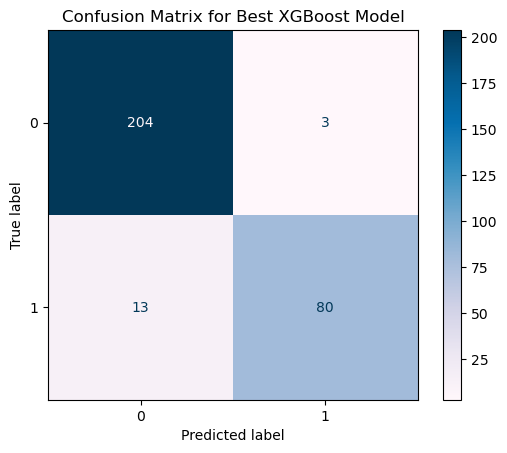

Confusion Matrix:
[[204   3]
 [ 13  80]]


In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
y_pred = best_xgboost_model.predict(X_test_transformed)
# Hitung confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Tampilkan visualisasi confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_xgboost_model.classes_)
disp.plot(cmap='PuBu')

# Tambahkan judul dan tampilkan plot
plt.title('Confusion Matrix for Best XGBoost Model')
plt.show()

# Jika ingin melihat angkanya saja
print("Confusion Matrix:")
print(cm)